### Gradient Descent Walkthrough

In [1]:
# Libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Synthetic data: intercept + one feature (so beta is 2D for plotting in parameter space)
rng = np.random.default_rng(42)

n = 200
x = rng.normal(size=n)
X = np.column_stack([np.ones(n), x])
beta_true = np.array([1.0, 2.0])
y = X @ beta_true + rng.normal(scale=0.5, size=n)

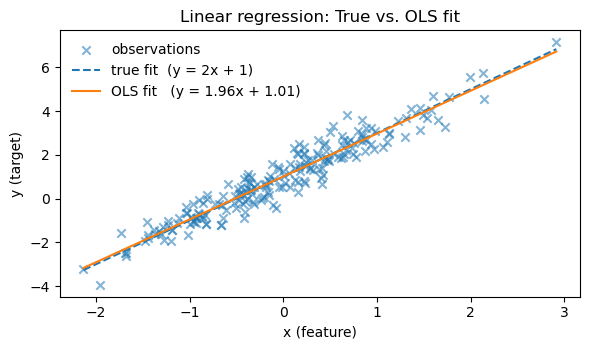

In [3]:
# True line & OLS fit
y_true = X @ beta_true                          # = 1 + 2*x
beta_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
y_pred = X @ beta_hat

# For clean line rendering, sort by x
order = np.argsort(x)
x_sorted = x[order]
y_true_sorted = y_true[order]
y_pred_sorted = y_pred[order]

# Plot
plt.figure(figsize=(6, 3.6))
plt.scatter(x, y, label="observations", alpha=0.55, marker="x")
plt.plot(x_sorted, y_true_sorted, "--", label="true fit  (y = 2x + 1)")
plt.plot(x_sorted, y_pred_sorted,
         label=f"OLS fit   (y = {beta_hat[1]:.2f}x + {beta_hat[0]:.2f})")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")
plt.title("Linear regression: True vs. OLS fit")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("plots/linear_regression_motivation.png", dpi=200)
plt.show()

In [4]:
# Standardize feature (common practical step)
Xs = X.copy()
Xs[:,1] = (Xs[:,1] - Xs[:,1].mean()) / Xs[:,1].std()

In [5]:
# Closed-form OLS
XtX = Xs.T @ Xs
Xty = Xs.T @ y
beta_ols = np.linalg.solve(XtX, Xty)

In [6]:
# Gradient Descent relevant functions
def loss(beta):
    """Training MSE using Xs and y defined in plotting cell."""
    r = Xs @ beta - y
    return (r @ r) / len(y)

def grad(beta, Xi=None, yi=None):
    """
    Gradient of squared loss.
    - Full batch if Xi/yi are None (uses Xs, y)
    - Otherwise uses provided (Xi, yi) mini-batch
    """
    if Xi is None:
        Xi = Xs
        yi = y
    r = Xi @ beta - yi
    return (2.0 / len(yi)) * (Xi.T @ r)

def run_gd(eta, steps, beta0=None):
    """
    Full-batch GD for a fixed number of steps.
    Returns (path, losses) for plotting.
    """
    if beta0 is None:
        beta = np.zeros(Xs.shape[1])
    else:
        beta = beta0.copy()

    path = [beta.copy()]
    losses = [loss(beta)]
    for _ in range(steps):
        g = grad(beta)        # full-batch gradient on (Xs, y)
        beta = beta - eta * g
        path.append(beta.copy())
        losses.append(loss(beta))
    return np.array(path), np.array(losses)

def run_minibatch(eta, steps, B, beta0=None, *, rng_=None, replace=False):
    """
    Mini-batch GD for a fixed number of steps.
    - Default replace=False to match plotting (choice without replacement).
    - Set replace=True to mimic the benchmarking script's with-replacement sampling.
    Returns (path, losses) for plotting.
    """
    if beta0 is None:
        beta = np.zeros(Xs.shape[1])
    else:
        beta = beta0.copy()

    if rng_ is None:
        rng_ = rng

    n = len(y)
    path = [beta.copy()]
    losses = [loss(beta)]
    for _ in range(steps):
        if replace:
            idx = rng_.integers(0, n, size=B)   # with replacement
        else:
            idx = rng_.choice(n, size=B, replace=False)  # without replacement
        Xi = Xs[idx]
        yi_batch = y[idx]
        g = grad(beta, Xi, yi_batch)
        beta = beta - eta * g
        path.append(beta.copy())
        losses.append(loss(beta))
    return np.array(path), np.array(losses)

In [7]:
# Trajectories: Batch GD, Mini-Batch GD, Stochastic GD
steps = 120
eta_bgd = 0.2
eta_mbgd = 0.15
eta_sgd = 0.05

path_bgd, loss_bgd = run_gd(eta_bgd, steps)
path_mbgd, loss_mbgd = run_minibatch(eta_mbgd, steps, B=32)
path_sgd, loss_sgd = run_minibatch(eta_sgd, steps, B=1)

# Contour grid for J(beta)
b0_vals = np.linspace(beta_ols[0]-2.0, beta_ols[0]+2.0, 200)
b1_vals = np.linspace(beta_ols[1]-2.0, beta_ols[1]+2.0, 200)
B0, B1 = np.meshgrid(b0_vals, b1_vals)
Z = np.zeros_like(B0)
for i in range(B0.shape[0]):
    for j in range(B0.shape[1]):
        Z[i,j] = loss(np.array([B0[i,j], B1[i,j]]))

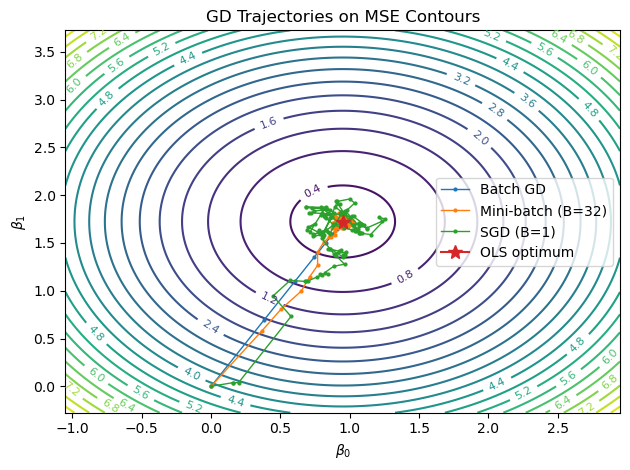

In [8]:
# Plot 1: Contours + trajectories
plt.figure()
cs = plt.contour(B0, B1, Z, levels=20)
plt.clabel(cs, inline=1, fontsize=8)
plt.plot(path_bgd[:,0], path_bgd[:,1], marker='o', markersize=2, linewidth=1, label='Batch GD')
plt.plot(path_mbgd[:,0], path_mbgd[:,1], marker='o', markersize=2, linewidth=1, label='Mini-batch (B=32)')
plt.plot(path_sgd[:,0], path_sgd[:,1], marker='o', markersize=2, linewidth=1, label='SGD (B=1)')
plt.plot([beta_ols[0]], [beta_ols[1]], marker='*', markersize=10, label='OLS optimum')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.title('GD Trajectories on MSE Contours')
plt.legend()
plt.tight_layout()
plt.savefig('plots/contours_paths.png', dpi=200)
plt.show()
plt.close()

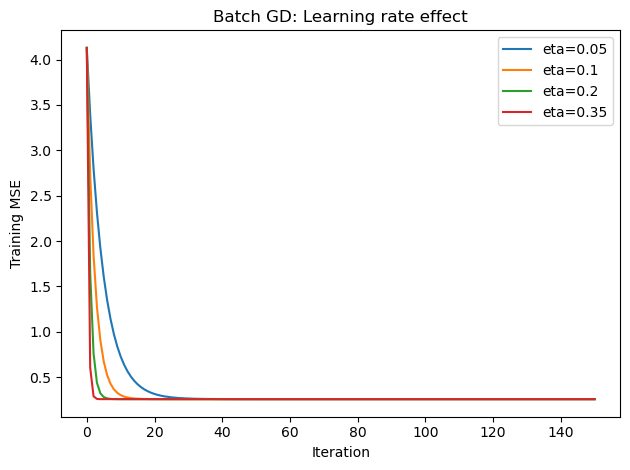

In [9]:
# Plot 2: Loss vs iterations for different learning rates (batch GD)
plt.figure()
for eta in [0.05, 0.1, 0.2, 0.35]:
    p, L = run_gd(eta, 150)
    plt.plot(L, label=f'eta={eta}')
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.title('Batch GD: Learning rate effect')
plt.legend()
plt.tight_layout()
plt.savefig('plots/loss_vs_iter_gd.png', dpi=200)
plt.show()
plt.close()


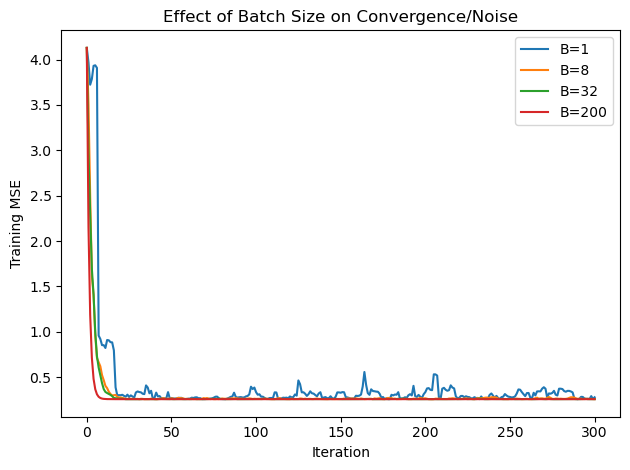

In [10]:
# Plot 3: Loss vs iterations for different batch sizes
plt.figure()
for B in [1, 8, 32, len(y)]:
    # choose eta a bit smaller for noisy estimates
    eta = 0.15 if B == len(y) else 0.08
    _, L = run_minibatch(eta, 300, B=B) if B != len(y) else run_gd(eta, 300)
    plt.plot(L, label=f'B={B}')
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.title('Effect of Batch Size on Convergence/Noise')
plt.legend()
plt.tight_layout()
plt.savefig('plots/batch_size_effect.png', dpi=200)
plt.show()
plt.close()

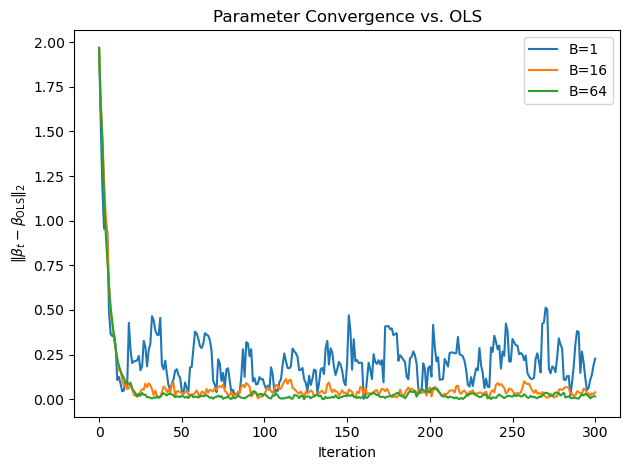

In [11]:
# Plot 4: Parameter distance to OLS over iterations (mini-batch)
plt.figure()
for B in [1, 16, 64]:
    path, L = run_minibatch(0.08, 300, B=B)
    dist = np.linalg.norm(path - beta_ols, axis=1)
    plt.plot(dist, label=f'B={B}')
plt.xlabel('Iteration')
plt.ylabel(r'$\|\beta_t - \beta_{\mathrm{OLS}}\|_2$')
plt.title('Parameter Convergence vs. OLS')
plt.legend()
plt.tight_layout()
plt.savefig('plots/param_distance.png', dpi=200)
plt.show()
plt.close()

### Wall Clock Benchmarking

In [12]:
# benchmarking helpers (for the consolidated bar chart)
def _full_loss(beta):
    """Helper to compute loss on the *full* design used by benchmark.
    If you want to reuse Xs here, it will match plotting data; if you want the
    big benchmark dataset, bind X/y to those before calling these bench functions.
    """
    r = X @ beta - y if 'X' in globals() and X is not None else Xs @ beta - y
    n_ = len(y)
    return (r @ r) / n_

def run_ols_bench():
    """OLS via lstsq. Returns (beta, seconds, train_mse)."""
    t0 = time.perf_counter()
    # Prefer X if defined (benchmark), else fall back to Xs (plotting toy set)
    Xuse = X if 'X' in globals() and X is not None else Xs
    beta, *_ = np.linalg.lstsq(Xuse, y, rcond=None)
    t1 = time.perf_counter()
    return beta, (t1 - t0), _full_loss(beta)

def run_gd_bench(eta, steps, beta0=None):
    """Full-batch GD. Returns (beta, seconds, train_mse)."""
    Xuse = X if 'X' in globals() and X is not None else Xs
    d = Xuse.shape[1]
    if beta0 is None:
        beta = np.zeros(d)
    else:
        beta = beta0.copy()

    t0 = time.perf_counter()
    for _ in range(steps):
        # Full-batch gradient on whichever design is active
        r = Xuse @ beta - y
        g = (2.0 / len(y)) * (Xuse.T @ r)
        beta = beta - eta * g
    t1 = time.perf_counter()
    return beta, (t1 - t0), _full_loss(beta)

def run_minibatch_bench(eta, steps, B, beta0=None, *, rng_=None, replace=True):
    """Mini-batch GD (default with replacement to mirror benchmark)."""
    Xuse = X if 'X' in globals() and X is not None else Xs
    d = Xuse.shape[1]
    if beta0 is None:
        beta = np.zeros(d)
    else:
        beta = beta0.copy()

    if rng_ is None:
        rng_ = rng

    n = len(y)
    t0 = time.perf_counter()
    for _ in range(steps):
        if replace:
            idx = rng_.integers(0, n, size=B)
        else:
            idx = rng_.choice(n, size=B, replace=False)
        Xi = Xuse[idx]
        yi_batch = y[idx]
        r = Xi @ beta - yi_batch
        g = (2.0 / len(yi_batch)) * (Xi.T @ r)
        beta = beta - eta * g
    t1 = time.perf_counter()
    return beta, (t1 - t0), _full_loss(beta)

def run_sgd_bench(eta, steps, beta0=None, *, rng_=None):
    """SGD with B=1. Returns (beta, seconds, train_mse)."""
    Xuse = X if 'X' in globals() and X is not None else Xs
    d = Xuse.shape[1]
    if beta0 is None:
        beta = np.zeros(d)
    else:
        beta = beta0.copy()

    if rng_ is None:
        rng_ = rng

    n = len(y)
    t0 = time.perf_counter()
    for _ in range(steps):
        i = rng_.integers(0, n)
        xi = Xuse[i]
        yi_ = y[i]
        g = 2.0 * xi * (xi @ beta - yi_)
        beta = beta - eta * g
    t1 = time.perf_counter()
    return beta, (t1 - t0), _full_loss(beta)

In [13]:
# Big synthetic dataset for benchmarking (n=80,000, d=40)
rng = np.random.default_rng(0)

n = 80000
d = 40
X = rng.normal(size=(n, d))
beta_true = rng.normal(size=d)
y = X @ beta_true + rng.normal(scale=0.5, size=n)

# Standardize columns of X (like before)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# (Optional) keep Xs aligned to X if plotting helpers might fall back to it
Xs = X

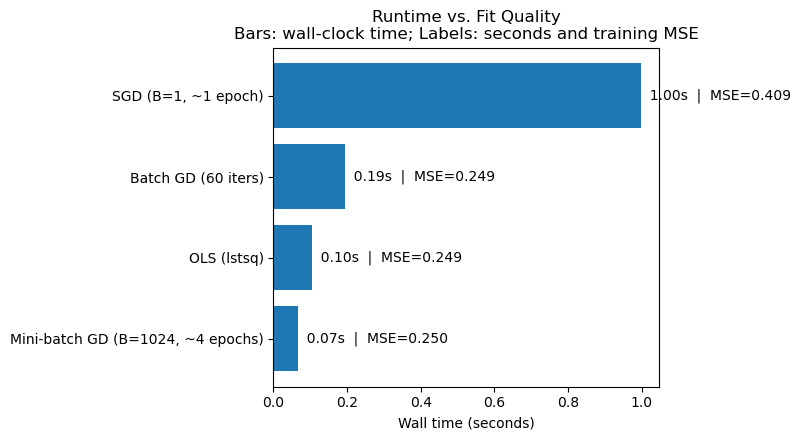

In [14]:
# Consolidated runtime vs MSE barplot
rows = []

# OLS
b, secs, mse_val = run_ols_bench()
rows.append(("OLS (lstsq)", secs, mse_val))

# Batch GD (fixed iters, like benchmark)
eta = 0.25
iters = 60
b, secs, mse_val = run_gd_bench(eta, iters)
rows.append((f"Batch GD ({iters} iters)", secs, mse_val))

# Mini-batch GD (~4 epochs)
n = len(y)
B = min(1024, n)                        # adapt to dataset size
steps = max(1, (n // B) * 4)            # ~4 epochs; ensure >=1 step
eta_mb = 0.08
b, secs, mse_val = run_minibatch_bench(eta_mb, steps, B=B, replace=True)
rows.append((f"Mini-batch GD (B={B}, ~4 epochs)", secs, mse_val))

# SGD (~1 epoch)
eta_sgd = 0.01
sgd_steps = max(1, n)                   # ~1 epoch; ensure >=1 step
b, secs, mse_val = run_sgd_bench(eta_sgd, sgd_steps)
rows.append(("SGD (B=1, ~1 epoch)", secs, mse_val))

# Assemble and sort
df = pd.DataFrame(rows, columns=["Method", "Wall time (s)", "Train MSE"]).sort_values("Wall time (s)", ascending=True)

# Plot
plt.figure(figsize=(8, 4.5))
y_pos = np.arange(len(df))
plt.barh(y_pos, df["Wall time (s)"])

# Annotate each bar with seconds and MSE
for i, (method, secs, mse_val) in enumerate(zip(df["Method"], df["Wall time (s)"], df["Train MSE"])):
    plt.text(secs, i, f"  {secs:.2f}s  |  MSE={mse_val:.3f}", va="center", ha="left")

plt.yticks(y_pos, df["Method"])
plt.xlabel("Wall time (seconds)")
plt.title("Runtime vs. Fit Quality\nBars: wall-clock time; Labels: seconds and training MSE")
plt.tight_layout()
barplot_path = "plots/runtime_with_mse_bars.png"
plt.savefig(barplot_path, dpi=200)
plt.show()
plt.close()